In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch_directml as tdml
# Set device
device = tdml.device()


In [2]:
# Define a basic transform
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [3]:
train_dataset = datasets.CIFAR10(root='./data',\
			train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
								batch_size=32, shuffle=True)


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


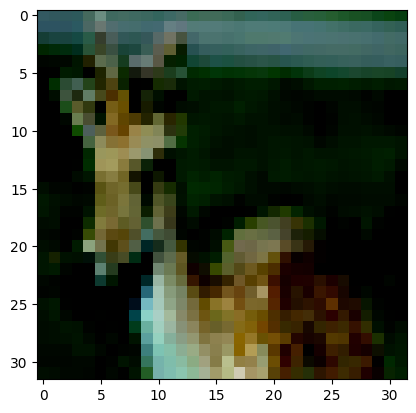

In [4]:
# plot some image from dataloader

# create a new figure
plt.figure()

# get the next batch of images from the data loader
images, labels = next(iter(dataloader))

# display the first image in the batch
images_show = np.transpose(images[0], (1, 2, 0))
plt.imshow(images_show.numpy())

# show the plot
plt.show()


In [5]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10


In [6]:
# Define the generator
class Generator(nn.Module):
	def __init__(self, latent_dim):
		super(Generator, self).__init__()

		self.model = nn.Sequential(
			nn.Linear(latent_dim, 128 * 8 * 8),
			nn.ReLU(),
			nn.Unflatten(1, (128, 8, 8)),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 128, kernel_size=3, padding=1),
			nn.BatchNorm2d(128, momentum=0.78),
			nn.ReLU(),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64, momentum=0.78),
			nn.ReLU(),
			nn.Conv2d(64, 3, kernel_size=3, padding=1),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		return img


In [7]:
# Define the discriminator
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()

		self.model = nn.Sequential(
		nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
		nn.ZeroPad2d((0, 1, 0, 1)),
		nn.BatchNorm2d(64, momentum=0.82),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
		nn.BatchNorm2d(128, momentum=0.82),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
		nn.BatchNorm2d(256, momentum=0.8),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Flatten(),
		nn.Linear(256 * 5 * 5, 1),
		nn.Sigmoid()
	)

	def forward(self, img):
		validity = self.model(img)
		return validity


In [8]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
						, lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
						, lr=lr, betas=(beta1, beta2))


c:\Users\ltensuba\AppData\Local\miniconda3\envs\torch\lib\site-packages\torch\nn\functional.py:3098: UserWarning: The operator 'aten::binary_cross_entropy' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at D:\a\_work\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch._C._nn.binary_cross_entropy(input, target, weight, reduction_enum)


Epoch [1/10]						Batch 100/1563 Discriminator Loss: 0.5881 Generator Loss: 1.1472
Epoch [1/10]						Batch 200/1563 Discriminator Loss: 0.7377 Generator Loss: 0.9380
Epoch [1/10]						Batch 300/1563 Discriminator Loss: 0.5841 Generator Loss: 1.0127
Epoch [1/10]						Batch 400/1563 Discriminator Loss: 0.5314 Generator Loss: 1.4034
Epoch [1/10]						Batch 500/1563 Discriminator Loss: 0.7500 Generator Loss: 0.8631
Epoch [1/10]						Batch 600/1563 Discriminator Loss: 0.6056 Generator Loss: 0.7797
Epoch [1/10]						Batch 700/1563 Discriminator Loss: 0.7254 Generator Loss: 0.8513
Epoch [1/10]						Batch 800/1563 Discriminator Loss: 0.6487 Generator Loss: 1.0169
Epoch [1/10]						Batch 900/1563 Discriminator Loss: 0.6426 Generator Loss: 0.9587
Epoch [1/10]						Batch 1000/1563 Discriminator Loss: 0.6340 Generator Loss: 0.9050
Epoch [1/10]						Batch 1100/1563 Discriminator Loss: 0.5884 Generator Loss: 0.9564
Epoch [1/10]						Batch 1200/1563 Discriminator Loss: 0.6002 Generator Loss: 0.9236
E

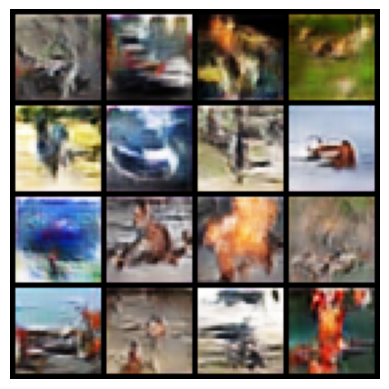

In [9]:
# Training loop
for epoch in range(num_epochs):
	for i, batch in enumerate(dataloader):
	# Convert list to tensor
		real_images = batch[0].to(device) 

		# Adversarial ground truths
		valid = torch.ones(real_images.size(0), 1, device=device)
		fake = torch.zeros(real_images.size(0), 1, device=device)

		# Configure input
		real_images = real_images.to(device)

		# ---------------------
		# Train Discriminator
		# ---------------------

		optimizer_D.zero_grad()

		# Sample noise as generator input
		z = torch.randn(real_images.size(0), latent_dim, device=device)

		# Generate a batch of images
		fake_images = generator(z)

		# Measure discriminator's ability 
		# to classify real and fake images
		real_loss = adversarial_loss(discriminator\
									(real_images), valid)
		fake_loss = adversarial_loss(discriminator\
									(fake_images.detach()), fake)
		d_loss = (real_loss + fake_loss) / 2

		# Backward pass and optimize
		d_loss.backward()
		optimizer_D.step()

		# -----------------
		# Train Generator
		# -----------------

		optimizer_G.zero_grad()

		# Generate a batch of images
		gen_images = generator(z)

		# Adversarial loss
		g_loss = adversarial_loss(discriminator(gen_images), valid)

		# Backward pass and optimize
		g_loss.backward()
		optimizer_G.step()

		# ---------------------
		# Progress Monitoring
		# ---------------------

		if (i + 1) % 100 == 0:
			print(
				f"Epoch [{epoch+1}/{num_epochs}]\
						Batch {i+1}/{len(dataloader)} "
				f"Discriminator Loss: {d_loss.item():.4f} "
				f"Generator Loss: {g_loss.item():.4f}"
			)

	# Save generated images for every epoch
	if (epoch + 1) % 10 == 0:
		with torch.no_grad():
			z = torch.randn(16, latent_dim, device=device)
			generated = generator(z).detach().cpu()
			grid = torchvision.utils.make_grid(generated,\
										nrow=4, normalize=True)
			plt.imshow(np.transpose(grid, (1, 2, 0)))
			plt.axis("off")
			plt.show()
